In [1]:
!ls

main.ipynb          main_original.ipynb


In [2]:
%cd ..

/Users/matthew/Documents/options-pricing-monte-carlo


# Analysis of the Black-Scholes Model: From Theory to Market Reality

### Project Overview

This project provides a rigorous, quantitative critique of the Black-Scholes model, a cornerstone of financial mathematics. The analysis is structured to mirror the workflow of a quantitative analyst: first validating a numerical method against the known analytical solution, then using that validated method to test the model's assumptions against empirical market data, and finally, simulating its practical application to measure its real-world performance and risks.

**The Narrative Arc:**

1.  **Model Validation:** We establish a "ground truth" by confirming that our numerical Monte Carlo (MC) engine correctly converges to the analytical Black-Scholes (BS) solution.
2.  **Assumption Testing:** We test the model's foundational assumption of constant volatility ($\sigma$) by analyzing live market data to reveal the "volatility smile."
3.  **Strategy Simulation:** We examine the practical consequences of the model's idealizations by simulating arbitrage and hedging strategies, introducing real-world frictions like transaction costs and discrete time steps.

## Part 1: Engine Validation & Performance Benchmark

### Mathematical Context

The Black-Scholes formula provides a deterministic, closed-form solution for the price of a European option under a set of ideal assumptions. A Monte Carlo simulation approaches the same problem stochastically. It models the option's underlying asset price, which is assumed to follow a **Geometric Brownian Motion (GBM)**, a stochastic differential equation of the form:

$$ dS_t = rS_t dt + \sigma S_t dW_t $$

where $S_t$ is the asset price, $r$ is the risk-free rate, $\sigma$ is the volatility, and $dW_t$ is a Wiener process. By simulating thousands of discrete paths of $S_t$ to the option's expiry time $T$, we calculate the payoff for each path, discount it back to the present value using $e^{-rT}$, and find the expected value by averaging the results.

### The Objective

The **Law of Large Numbers** dictates that as the number of simulated paths ($N$) approaches infinity, the average payoff from the MC simulation should converge to the true expected value, which is the Black-Scholes price.

This section's purpose is to numerically verify this convergence. By showing that our MC price matches the BS price with high **accuracy**, we validate that our simulation engine is a correct implementation of the model. We also benchmark the computational performance using **Numba**, a Just-in-Time (JIT) compiler that translates our Python simulation loops into much faster machine code, a critical step for practical applications.

In [3]:
import numpy as np
import pandas as pd
from src.models.monte_carlo import OptimizedMCEngine

# 1. Define the parameters for our test option
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate
sigma = 0.13   # Volatility

# 2. Initialize the high-performance Numba engine
# The first run will be a bit slower as Numba compiles the functions.
print("Initializing and warming up the Numba JIT compiler...")
engine_numba = OptimizedMCEngine(use_numba=True, use_antithetic=True)
print("Initialization complete.")


# 3. Run the benchmark on the high-performance Numba engine
print("\n" + "="*50)
print("PERFORMANCE: Numba-Optimized Engine")
print("="*50)
numba_results = engine_numba.benchmark_performance(S0, K, T, r, sigma)
display(numba_results)

Initializing and warming up the Numba JIT compiler...
Initialization complete.

PERFORMANCE: Numba-Optimized Engine
--- Benchmarking Engine (Numba: True, Antithetic: True) ---


,simulations,time_seconds,sims_per_second,memory_mb,accuracy_pct,mc_price,analytical_price
0,"10,000",0.4832,"20,697",6.56,99.3534%,5.27403,5.24015
1,"50,000",0.0005,"100,582,829",0.00,99.9062%,5.24506,5.24015
2,"100,000",0.0006,"156,212,439",0.00,99.9271%,5.24397,5.24015
3,"500,000",0.0025,"196,934,172",0.00,99.9891%,5.23958,5.24015
4,"1,000,000",0.0059,"170,092,217",0.00,99.8355%,5.24876,5.24015


## Part 2: Quantifying the Theory-Practice Gap via Implied Volatility

### Mathematical Context

The Black-Scholes model's most significant—and most frequently violated—assumption is that volatility, $\sigma$, is a known constant for a given asset over the life of the option. If this were true, all options on the same underlying asset with the same expiry date should be priced by the market with the same $\sigma$.

Here, we test this hypothesis. For each option traded in the market, we take its price, $C_{market}$, as a given. The BS formula can be written as a function of volatility, $C_{BS}(\sigma)$. We then solve the inverse problem: find the value of $\sigma$ that satisfies the equation:

$$ C_{market} - C_{BS}(\sigma_{implied}) = 0 $$

This value, $\sigma_{implied}$, is the **implied volatility**. We solve for it numerically using a root-finding algorithm (Brent's method).

### The Objective

If the Black-Scholes model were a perfect representation of reality, the calculated $\sigma_{implied}$ would be the same for all options, regardless of their strike price ($K$).

This analysis plots $\sigma_{implied}$ against $K$. The resulting non-flat curve, known as the **volatility smile** (or skew), is a powerful piece of empirical evidence that the model's constant volatility assumption is incorrect. The `ModelBreakdownAnalyzer` quantifies the pricing error that would result from naively using a single constant volatility (e.g., the at-the-money value) compared to observed market prices.

Fetching option surface and market price for SPY...
Fetched 279 liquid call options.
Using live risk-free rate: 4.24%
Using constant volatility benchmark: 13.00%
Calculated breakdown metrics for 279 options.

--- Black-Scholes Model Breakdown Analysis ---


,strike,moneyness,days_to_expiry,market_price,bs_price_at_13_vol,pricing_error_pct,implied_vol_pct,bid_ask_spread_pct
0,265.00,2.39,13,287.00,367.48,28.04,NaN,0.74
1,300.00,2.11,13,328.49,332.53,1.23,NaN,0.00
2,320.00,1.98,13,278.83,312.56,12.10,NaN,0.73
3,340.00,1.86,13,292.30,292.59,0.10,NaN,0.00
4,350.00,1.81,13,284.17,282.61,-0.55,164.51,0.00
...,...,...,...,...,...,...,...,...
274,770.00,0.82,111,0.06,0.08,31.80,12.62,0.00
275,775.00,0.82,111,0.05,0.06,18.85,12.77,0.00
276,780.00,0.81,111,0.05,0.04,-11.14,13.15,0.00
277,790.00,0.80,111,0.03,0.02,-18.46,13.24,0.00



--- Key Performance Metrics ---
Options Analyzed: 239
Avg Pricing Error (vs 13% Vol): 9.19%
Avg Error for OTM Options: 30.70%
Avg Error for ITM Options: -5.37%
Implied Vol Range: 10.4% - 164.5%
Avg Bid-Ask Spread: 1.05%

--- Implied Volatility Smile Plot ---


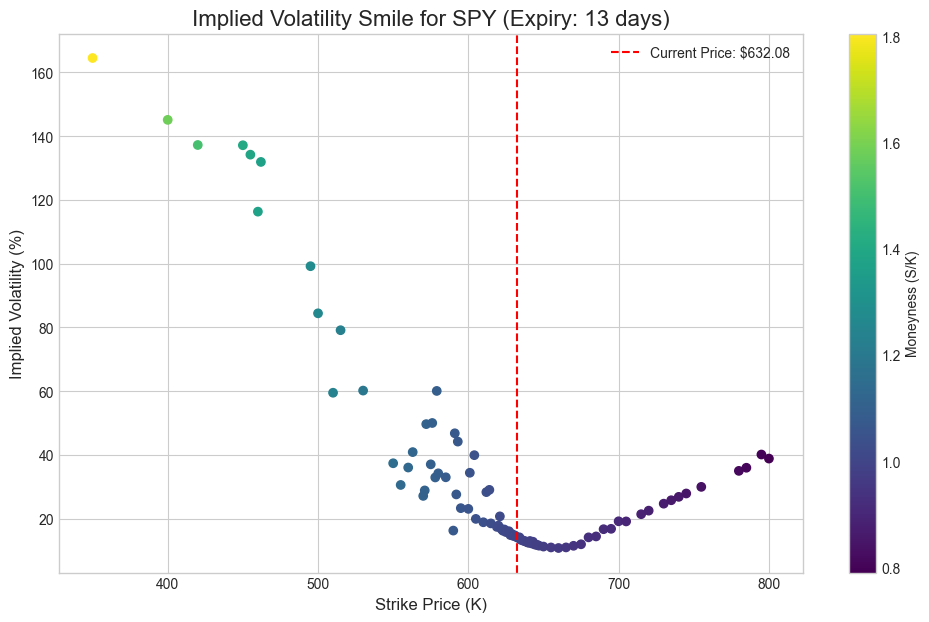

In [4]:
import pandas as pd
from src.models.model_validation import ModelBreakdownAnalyzer
from src.market_data.fetcher import get_risk_free_rate # Import the rate fetcher

# To display DataFrames nicely
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Define Parameters ---
# Fetch the live risk-free rate once
live_r = get_risk_free_rate() 

# 1. Initialize the analyzer
analyzer = ModelBreakdownAnalyzer(ticker='SPY')

# 2. Run the analysis steps, passing in our parameters
analyzer.fetch_market_data()
breakdown_df = analyzer.calculate_model_errors(r=live_r, constant_vol=sigma)

# 3. Display the detailed breakdown DataFrame
print("\n--- Black-Scholes Model Breakdown Analysis ---")
display(breakdown_df)

# 4. Generate and print the final killer metrics
print("\n--- Key Performance Metrics ---")
key_metrics = analyzer.generate_key_metrics()
for key, value in key_metrics.items():
    print(f"{key}: {value}")

# 5. NEW: Plot the volatility smile
print("\n--- Implied Volatility Smile Plot ---")
analyzer.plot_volatility_smile()

## Part 3: Arbitrage Scanning & Market Frictions

### Mathematical Context

**Put-Call Parity** is a cornerstone no-arbitrage condition derived from constructing a risk-free portfolio. It states that the difference between a European call price ($C$) and a European put price ($P$) with the same strike ($K$) and expiry ($T$) must equal the present value of the underlying asset price ($S_0$) minus the strike price:

$$ C - P = S_0 - Ke^{-rT} $$

A deviation from this parity would, in a perfect and frictionless market, represent a risk-free profit opportunity.

### The Objective

This section scans the market for such theoretical arbitrage opportunities. However, its primary purpose is to introduce the concept of **market microstructure** and **transaction costs**. In the real world, trades are not executed at a single `lastPrice`, but within a **bid-ask spread**.

* **Bid Price**: The price at which a market maker is willing to *buy* an asset. This is the price you *sell* at.
* **Ask Price**: The price at which a market maker is willing to *sell* an asset. This is the price you *buy* at.
* **The Spread**: The difference (Ask - Bid) is the market maker's profit and the trader's cost of execution.

Our enhanced scanner checks if the theoretical arbitrage profit is large enough to overcome the cost of **crossing the spread** (i.e., buying the call at its ask and selling the put at its bid). The result shows that the market is largely efficient; while theoretical opportunities exist, they are almost always smaller than the transaction costs required to exploit them.

In [5]:
from src.strategies.arbitrage import ArbitrageScanner

# Initialize and run the scanner with the new bid-ask logic
scanner = ArbitrageScanner()
executable_violations = scanner.scan_put_call_parity_violations()

# Display the results
print("\n--- EXECUTABLE Arbitrage Opportunities (After Bid-Ask Spread) ---")
if executable_violations.empty:
    print("No executable arbitrage opportunities found.")
else:
    # Display key columns for the profitable strategies
    display(executable_violations[['ticker', 'strike', 'strategy', 'executable_profit']])

Scanning for EXECutable Put-Call Parity violations using r=4.24%...

--- EXECUTABLE Arbitrage Opportunities (After Bid-Ask Spread) ---
No executable arbitrage opportunities found.


## Part 4: Simulating and Measuring Model Risk via Delta Hedging

### Mathematical Context

**Delta ($\Delta$)** is the first partial derivative of the option price ($V$) with respect to the underlying asset price ($S$): $\Delta = \frac{\partial V}{\partial S}$. It represents the rate of change of the option's value for a small change in the asset's price.

**Delta Hedging** is a strategy used to create a risk-neutral portfolio by holding an option position and an offsetting position in the underlying asset. For a short call option (position value $-C$), the portfolio value ($\Pi$) is made insensitive to small price changes by holding $\Delta$ shares of the underlying:

$$ \Pi = -C + \Delta S $$

As the stock price $S$ and time $t$ change, $\Delta$ also changes, so the hedge must be periodically rebalanced.

### The Objective

In a perfect, continuous-time Black-Scholes world, this strategy would result in a final Profit & Loss (P&L) of exactly zero. This simulation tests that idealization.

We simulate thousands of market paths and rebalance the hedge at **discrete time intervals** (daily). The resulting histogram of final P&L shows a distribution centered near zero, but with a non-zero variance. This variance is the **hedging error**. It is a direct, quantifiable measurement of **model risk** and the P&L impact of real-world frictions (like non-continuous hedging) that are not captured by the theoretical model.

Running Delta Hedging simulation...
Simulation complete.

--- Hedging Performance Results ---
Average Hedging P&L: 0.0079
Standard Deviation of P&L (Hedging Error): 0.4576


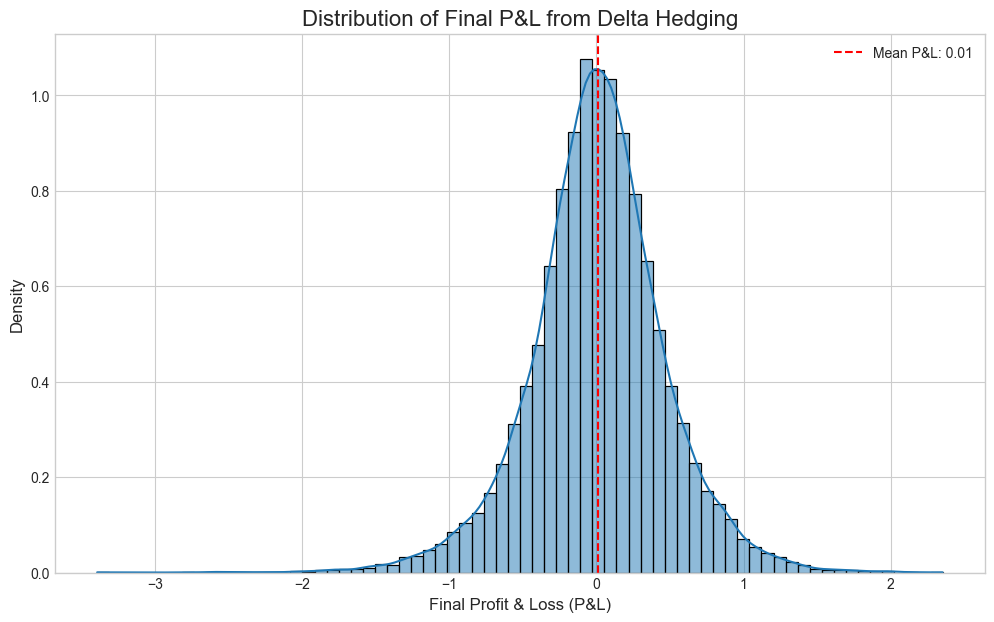

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.risk.hedging import simulate_delta_hedging

# --- Main Analysis Block for Delta Hedging Simulation ---

# 1. Define the parameters for the option we are hedging
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate
sigma = 0.2   # Assumed volatility for our hedging model
n_simulations = 20000 # Number of market scenarios to simulate
steps = 252   # Daily hedging

# 2. Run the simulation
print("Running Delta Hedging simulation...")
final_pnl = simulate_delta_hedging(S0, K, T, r, sigma, n_simulations, steps)
print("Simulation complete.")

# 3. Analyze and plot the results
mean_pnl = np.mean(final_pnl)
std_pnl = np.std(final_pnl)

print(f"\n--- Hedging Performance Results ---")
print(f"Average Hedging P&L: {mean_pnl:.4f}")
print(f"Standard Deviation of P&L (Hedging Error): {std_pnl:.4f}")

# Plot the distribution of the final P&L
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.histplot(final_pnl, bins=70, kde=True, stat="density")
plt.axvline(mean_pnl, color='r', linestyle='--', label=f'Mean P&L: {mean_pnl:.2f}')
plt.title('Distribution of Final P&L from Delta Hedging', fontsize=16)
plt.xlabel('Final Profit & Loss (P&L)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [ ]:
from src.strategies.market_impact import MarketImpactAnalyzer
import pandas as pd

# Notebook settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

# --- Main Block for Comprehensive Market & Liquidity Analysis ---

# 1. Initialize the analyzer
analyzer = MarketImpactAnalyzer(tickers=['SPY', 'QQQ', 'AAPL', 'TSLA'])

# 2. Run the full analysis pipeline in the correct order
# This first fetches the data, then runs the analysis to populate the metrics.
analyzer.analyze_liquidity_constraints() 

# 3. Now, generate the summary from the analyzed metrics
liquidity_summary = analyzer.generate_executive_summary()

# --- Display the Executive Summary ---
print("\n" + "="*50)
print("      LIQUIDITY & STRATEGY CAPACITY SUMMARY")
print("="*50)

if liquidity_summary.empty:
    print("Analysis failed to generate a summary. Check debug output above.")
else:
    display(liquidity_summary)

Fetching comprehensive market data...
--> Processing ticker: SPY
--> Processing ticker: QQQ
--> Processing ticker: AAPL
--> Processing ticker: TSLA

      LIQUIDITY & STRATEGY CAPACITY SUMMARY


{}

In [8]:
from src.utils.transaction_cost import TransactionCostCalculator

# --- Analyze Net Profit of Found Opportunities ---
# We use the 'executable_violations' DataFrame from our Part 3 scan
if 'executable_violations' in locals() and not executable_violations.empty:
    cost_analyzer = TransactionCostCalculator()
    net_profit_results = []
    
    # Analyze the top 5 opportunities
    for index, opportunity in executable_violations.head(5).iterrows():
        # Assume a standard position size of 10 contracts
        net_profit_analysis = cost_analyzer.calculate_arbitrage_profit_after_costs(
            opportunity.to_dict(), position_size=10
        )
        net_profit_results.append(net_profit_analysis)

    net_profit_df = pd.DataFrame(net_profit_results)
    
    print("\n" + "="*50)
    print("      NET PROFIT ANALYSIS OF TOP ARBITRAGE OPPORTUNITIES")
    print("="*50)
    display(net_profit_df[['ticker', 'strike', 'strategy', 'gross_profit', 'commission_cost', 'net_profit', 'is_profitable']])
else:
    print("\nNo arbitrage opportunities were found to analyze for net profitability.")


No arbitrage opportunities were found to analyze for net profitability.
